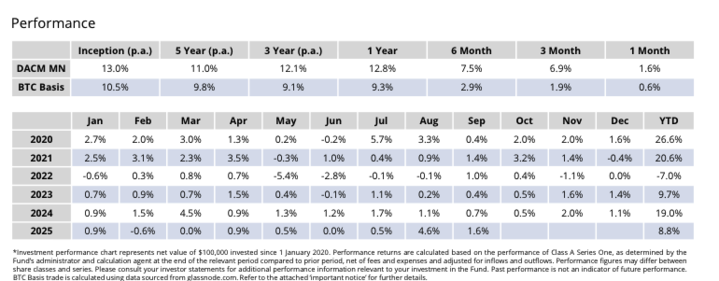

In [1]:
import pandas as pd
import plotly.express as px

from mainnet_launch.constants import *
from multicall import Call
from mainnet_launch.data_fetching.get_state_by_block import (
    safe_normalize_6_with_bool_success,
    safe_normalize_with_bool_success,
    build_blocks_to_use,
    Call,
    get_raw_state_by_blocks,
)

eth_calls = [
    Call(
        AUTO_ETH.autopool_eth_addr,
        ["convertToAssets(uint256)(uint256)", int(1e18)],
        [(AUTO_ETH.name, safe_normalize_with_bool_success)],
    ),
    Call(
        AUTO_USD.autopool_eth_addr,
        ["convertToAssets(uint256)(uint256)", int(1e18)],
        [(AUTO_USD.name, safe_normalize_6_with_bool_success)],
    ),
]

eth_blocks = build_blocks_to_use(ETH_CHAIN)

eth_df = get_raw_state_by_blocks(
    eth_calls,
    eth_blocks,
    ETH_CHAIN,
)


base_calls = [
    Call(
        BASE_ETH.autopool_eth_addr,
        ["convertToAssets(uint256)(uint256)", int(1e18)],
        [(BASE_ETH.name, safe_normalize_with_bool_success)],
    ),
    Call(
        BASE_USD.autopool_eth_addr,
        ["convertToAssets(uint256)(uint256)", int(1e18)],
        [(BASE_USD.name, safe_normalize_6_with_bool_success)],
    ),
]

base_blocks = build_blocks_to_use(BASE_CHAIN)
base_df = get_raw_state_by_blocks(
    base_calls,
    base_blocks,
    BASE_CHAIN,
)

end_of_day_mainnet_eth_df = eth_df.resample(
    "D",
).last()
end_of_day_base_df = base_df.resample(
    "D",
).last()

combined_df = pd.concat([end_of_day_mainnet_eth_df, end_of_day_base_df])
print(combined_df.index.max())
px.line(combined_df)

/Users/pb/Library/Caches/pypoetry/virtualenvs/mainnet-launch-FtycU18g-py3.10/lib/python3.10/site-packages/web3/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


2025-12-10 00:00:00+00:00


In [2]:
monthly_percent_change = combined_df.resample("ME").last().pct_change() * 100

for column in monthly_percent_change.columns:
    if column not in ["autoETH", "baseUSD"]:
        first_non_na_index = monthly_percent_change[column].first_valid_index()
        monthly_percent_change.loc[first_non_na_index, column] = None  # exclude the first month, since it is partial

    # exclude the last month since it is partial
    # autoUSD should exclude should not have april 2025 data since is partial

    monthly_percent_change.loc[monthly_percent_change.index[-1], column] = None

monthly_percent_change.index = monthly_percent_change.index.strftime("%B %Y")
monthly_percent_change = monthly_percent_change[[AUTO_ETH.name, AUTO_USD.name, BASE_ETH.name, BASE_USD.name]]
monthly_percent_change = monthly_percent_change.round(2)
monthly_percent_change.index.name = "Month"

from pprint import pprint

print("First full months, excluding partial last month:")
pprint(monthly_percent_change)

First full months, excluding partial last month:
                autoETH  autoUSD  baseETH  baseUSD
Month                                             
September 2024      NaN      NaN      NaN      NaN
October 2024       0.11      NaN      NaN      NaN
November 2024      0.49      NaN      NaN      NaN
December 2024      0.70      NaN     0.77      NaN
January 2025       0.41      NaN     0.18      NaN
February 2025      0.67      NaN     0.90      NaN
March 2025         0.57      NaN     0.60      NaN
April 2025         0.53      NaN    -0.08      NaN
May 2025           0.39     0.59     0.43      NaN
June 2025          0.29     0.60     0.40     0.66
July 2025          0.26     0.70     0.24     0.76
August 2025        0.22     0.88     0.23     0.74
September 2025     0.42     0.79     0.44     0.79
October 2025       0.11     0.66     0.36     0.64
November 2025     -3.42     0.54     0.33     0.62
December 2025       NaN      NaN      NaN      NaN


# Total return numbers are only up to Nov 30, 2025

In [ ]:
print('only up to november 2025 total return numbers')
def _compute_return_since_inception(column:str, combined_df:pd.DataFrame):

    first_non_na_index = combined_df[column].first_valid_index()
    
    last_day_of_november = pd.Timestamp("2025-11-30", tz="UTC")
    days_between = (last_day_of_november - first_non_na_index).days
    start_value = 1
    end_value_a, end_value_b = combined_df.loc[last_day_of_november, column].values
    end_value_a = end_value_a if not pd.isna(end_value_a) else end_value_b
    end_value_b = end_value_b if not pd.isna(end_value_b) else end_value_a
    end_value = end_value_a if not pd.isna(end_value_a) else end_value_b
    total_return = round((end_value / start_value) - 1, 4)
    # annualized_return = (1 + total_return) ** (365 / days_between) - 1
    return total_return, days_between

for column in combined_df.columns:
    total_return, days_between = _compute_return_since_inception(column, combined_df)
    print(f"Total return since inception for {column}: {total_return:.2%}")

# ann_return


only up to november 2025 total return numbers
Total return since inception for autoETH: 1.80% 
Total return since inception for autoUSD: 5.26% 
Total return since inception for baseETH: 5.19% 
Total return since inception for baseUSD: 4.44% 


In [45]:
pprint("Simple Annualized (x12) monthly returns")
pprint(monthly_percent_change * 12)

'Simple Annualized (x12) monthly returns'
                autoETH  autoUSD  baseETH  baseUSD
Month                                             
September 2024      NaN      NaN      NaN      NaN
October 2024       1.32      NaN      NaN      NaN
November 2024      5.88      NaN      NaN      NaN
December 2024      8.40      NaN     9.24      NaN
January 2025       4.92      NaN     2.16      NaN
February 2025      8.04      NaN    10.80      NaN
March 2025         6.84      NaN     7.20      NaN
April 2025         6.36      NaN    -0.96      NaN
May 2025           4.68     7.08     5.16      NaN
June 2025          3.48     7.20     4.80     7.92
July 2025          3.12     8.40     2.88     9.12
August 2025        2.64    10.56     2.76     8.88
September 2025     5.04     9.48     5.28     9.48
October 2025       1.32     7.92     4.32     7.68
November 2025    -41.04     6.48     3.96     7.44
December 2025       NaN      NaN      NaN      NaN
